In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob

In [9]:
##Biomass data:
path = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Pennings' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

df = df[df['Zone'] >= 0] ##Zone "-1" in 2013 needs to be addressed - refers to old plot location that was relocated

df_sum = df.groupby(['Plot', 'Zone', 'Site', 'Year'], as_index = False).aggregate(
    {
        'Plant_Biomass':[np.sum, np.size],'Longitude':[np.mean], 'Latitude':[np.mean], 'Quadrat_Area':[np.mean], 
        'Species_Code':'first', 'Flowering_Status':'first','Date':'first'
    }
) 

df_sum.columns = [
    'Plot','Zone','Site','Year','Plant_Biomass', 'Sample_Size', 'Longitude', 'Latitude', 'Quadrat_Area', 'Species_Code',
    'Flowering_Status', 'Date'
]

df_sum['Plant_Biomass'] = df_sum['Plant_Biomass']/df_sum['Quadrat_Area']

In [10]:
##Remote sensing data:

df_rs = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Streamlined/df_remotedata.csv')

df1 = pd.merge(df_rs, df_sum, how = 'right')

display(df1)

,Site,Month,Year,Zone,Plot,Latitude,Day,Longitude,B2,B3,...,nd_r_g,nd_g_b,nd_swir2_nir,nd_swir2_r,Plant_Biomass,Sample_Size,Quadrat_Area,Species_Code,Flowering_Status,Date
0,1,NaN,2000,1,1,31.538627,NaN,-81.422539,NaN,NaN,...,NaN,NaN,NaN,NaN,516.324,23,0.25,A1,0.0,2000-10-11
1,1,10.0,2001,1,1,31.538627,17.0,-81.422539,0.058550,0.057500,...,-0.009048,0.112378,-0.307900,0.034344,424.416,18,0.25,A1,1.0,2001-10-17
2,1,10.0,2002,1,1,31.538627,16.0,-81.422539,0.058550,0.057500,...,-0.009048,0.112378,-0.307900,0.034344,259.784,16,0.25,A1,0.0,2002-10-16
3,1,10.0,2004,1,1,31.538627,25.0,-81.422539,0.055013,0.053362,...,-0.015225,0.103008,-0.346465,0.068209,436.332,18,0.25,A1,0.0,2004-10-25
4,1,10.0,2005,1,1,31.538627,24.0,-81.422539,0.044100,0.040987,...,-0.036580,0.160526,-0.421449,0.098061,649.300,25,0.25,A1,0.0,2005-10-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,6,10.0,2018,1,64,31.388000,12.0,-81.279858,0.050523,0.064415,...,-0.006369,0.120867,-0.394170,-0.077615,809.024,15,0.25,A1,0.0,2018-10-12
3212,6,10.0,2019,1,64,31.388000,9.0,-81.279858,0.048622,0.062111,...,-0.003861,0.121814,-0.405951,-0.100704,295.636,8,0.25,A1,0.0,2019-10-09
3213,1,10.0,2017,1,65,31.538420,14.0,-81.422320,0.026680,0.038920,...,-0.005685,0.186585,-0.439780,-0.114716,620.504,26,0.25,A1,1.0,2017-10-14
3214,1,NaN,2018,1,65,31.538420,NaN,-81.422320,NaN,NaN,...,NaN,NaN,NaN,NaN,276.676,20,0.25,A1,0.0,2018-10-13


In [26]:
##Modeling
df1.rename(columns={'elevation':'Elevation'}, inplace=True)

df1 = df1[df1['ndvi'].notna()] ##remove rows with NaN for columns used in the model 
df1 = df1[df1['prcp'].notna()] ##CAREFUL; added 7/11/22
df1 = df1[df1['Species_Code'] == 'A1'] ##careful here
df1 = df1[(df1['flats'] < 0.1)] ##TIDAL FILTERING STEP! Increases NRMSE, but seems to be a better fit

from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime

df1['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
df1['DOY'] = df1['Date'].dt.strftime('%j') ##Add day of year (DOY) to dataset
# df1['DOY'] = df1['Date'].dt.strftime('%j').astype('float') ##The astype('float') is only for the regression - not for ML 

xargs=df1[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b','wdrvi5', 'savi', 
        'Elevation', 'tmax', 'tmin', 'DOY' 
    ]
]

yargs=df1['Plant_Biomass'] 

##NEED SEASONAL DAYMET DATA
#removed: 'nd_r_g','dayl','sn_prcp', 'sn_dayl', 'sn_srad', 'sn_vp', 'vp', 'srad', 'prcp'

##Include lag variables (e.g. lag ndvi), precip, temp, more

##ELEVATION NEEDS TO BE TRIPLE-CHECKED AT EACH PLOT TO MAKE SURE VALUES CORRESPOND

size_x = 0.2
seed = 3
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed) 
## 80% training and 20% test

In [27]:
#Pipeline:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics
pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
pipe.fit(xargs_train, yargs_train)
y_pred=pipe.predict(xargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred)))
r_square = metrics.r2_score(yargs_test, y_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('testing r2 is: ' + str(pipe.score(xargs_test, yargs_test)))
print('training r2 is: ' + str(pipe.score(xargs_train, yargs_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(yargs_test, y_pred))/np.ptp(yargs_test)))

# Mean
print('MEAN BASELINE:')
y_pred_mean = [np.mean(yargs_train)] * len(yargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred_mean))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred_mean)))

# NDVI

print('NDVI BASELINE: unfinished')

Mean Absolute Error: 331.68087090945676
Mean Squared Error: 253868.4223482891
Root Mean Squared Error: 503.85357232859735
The r squared is: 0.30577114541821904
0.30577114541821904
testing r2 is: 0.30577114541821904
training r2 is: 0.8688205043760541
NRMSE is: 0.1482326859591669
MEAN BASELINE:
Mean Absolute Error: 434.042973647539
Root Mean Squared Error: 604.76579882157
NDVI BASELINE: unfinished


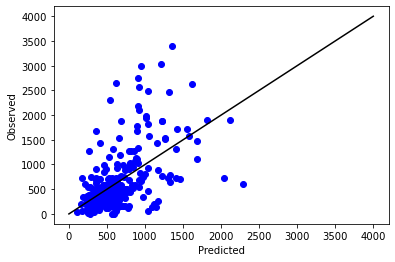

test data correlation coefficient is: 0.5542670238273284
train data correlation coefficient is: 0.9509577692559544


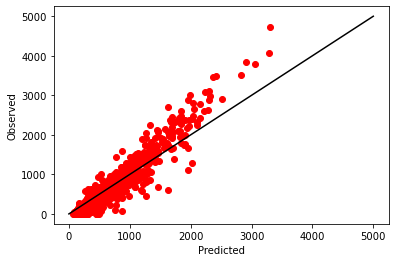

In [21]:
plt.scatter(y_pred, yargs_test, color = 'blue') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 4000], [0, 4000], 'k-')
plt.show()

print('test data correlation coefficient is: ' + str(np.corrcoef(yargs_test, y_pred)[0, 1]))

train_pred = pipe.predict(xargs_train) ##Not sure if this is the right thing to do here
plt.scatter(train_pred, yargs_train, color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 5000], [0, 5000], 'k-')
plt.show

print('train data correlation coefficient is: ' + str(np.corrcoef(train_pred, yargs_train)[0, 1]))

In [23]:
##k-fold cross validation; random forest

predictors = df1[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b','wdrvi5', 'savi', 
        'Elevation', 'tmax', 'tmin', 'DOY' 
    ]
]

targets = df1['Plant_Biomass'] 

from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import KFold, cross_validate
from sklearn.datasets import load_boston

X, y = predictors, targets
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

model = pipe
scoring=('r2', 'neg_root_mean_squared_error')

cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False)
cv_results

##from: https://stackoverflow.com/questions/55270431/how-to-correctly-perform-cross-validation-in-scikit-learn

{'fit_time': array([0.49081516, 0.49389696, 0.49156737, 0.49037671, 0.49198437]),
 'score_time': array([0.01208854, 0.01097083, 0.01196885, 0.01205659, 0.01118016]),
 'test_r2': array([0.23530964, 0.24476968, 0.30042116, 0.1679968 , 0.32047547]),
 'test_neg_root_mean_squared_error': array([-567.19363103, -494.65460498, -531.70020956, -505.80165687,
        -512.23746543])}